In [15]:
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import statsmodels.api as sm

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from math import sqrt

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# special matplotlib argument for improved plots
from matplotlib import rcParams

In [30]:
class Rossman():
    train_file_path = ''
    test_file_path = ''
    stores_file_path = ''
    
    def __init__(self, train_file_path, test_file_path, stores_file_path):
        """
        Sets in the file path for training, test and store
        info csv's
        """
        
        self.train_file_path = train_file_path
        self.test_file_path = test_file_path
        self.stores_file_path = stores_file_path
    
    
    def load_dataset(self):
        self.train_df = pd.read_csv(self.train_file_path, parse_dates=['Date'])
        self.test_df = pd.read_csv(self.test_file_path, parse_dates=['Date'])
        self.stores_df = pd.read_csv(self.stores_file_path)
        
        return (self.train_df, self.test_df, self.stores_df)
    
    def non_zero_sales_data(self):
        mask = self.train_df.Sales > 0
        return self.train_df[mask]
    
    def split_train_test(self):
        """
        Splits the train_df into training and testing set
        training data will have all the examples except for last 6 weeks
        test data will examples for last 6 weeks
        """
        mask_tr = self.train_df.Date < '2015-05-01'
        mask_test = self.train_df.Date >= '2015-06-15'
        self.training_examples = self.train_df[mask_tr]
        self.test_examples = self.train_df[mask_test]
    
    def merge_stores_data(self):
        """
        Merge store information with training data and test data
        """
        
        self.train_df = pd.merge(self.train_df, self.stores_df, on='Store', how='left')
        self.test_df = pd.merge(self.test_df, self.stores_df, on='Store', how='left')

    
    def rmspe(self, y_true, y_pred):
        """
        Root Mean Square Percentage Error

        Args:
        y_true: true values for y
        y_pred: estimated values for y

        Returns: rmspe
        """

        n = len(y_true)
        e = []
        for i in range(n):
            if y_true[i] != 0:
                e.append((y_true[i] - y_pred[i]) / np.float(y_true[i]))
            else:
                e.append(0.0)

        e = np.array(e)
        e_squared = e ** 2

        return sqrt(np.sum(e_squared) / n)
        
    

In [561]:
rossman = Rossman('./data/train.csv', './data/test.csv', './data/store.csv')

In [562]:
# load training, testing and stores info
train_df, test_df, stores_df = rossman.load_dataset()

In [317]:
# shape of the training dataset
print 'Shape of the training dataset  ', (train_df.shape)

Shape of the training dataset   (1017209, 9)


In [318]:
# shape of the test dataset
print 'Shape of the test dataset ', (test_df.shape)

Shape of the test dataset  (41088, 8)


In [7]:
# shape of the store info dataset
print 'Shape of the store info dataset ', (stores_df.shape)

Shape of the store info dataset  (1115, 10)


** This contains information regarding 1,115 stores in Germany **

In [8]:
# lets look at some of the examples for each of the dataset
train_df.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [9]:
test_df.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1,1,0,0
1,2,3,4,2015-09-17,1,1,0,0
2,3,7,4,2015-09-17,1,1,0,0


In [10]:
stores_df.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,2,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"


## Exploratory Data Analysis

** Lets take look at general information about our data e.g. type of features ( string, float etc.), count and names **

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Date             1017209 non-null datetime64[ns]
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: datetime64[ns](1), int64(7), object(1)
memory usage: 77.6+ MB


** Following are some of the observations **
* No missing values in training data
* State Holiday in interpreted as an object

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41088 entries, 0 to 41087
Data columns (total 8 columns):
Id               41088 non-null int64
Store            41088 non-null int64
DayOfWeek        41088 non-null int64
Date             41088 non-null datetime64[ns]
Open             41077 non-null float64
Promo            41088 non-null int64
StateHoliday     41088 non-null object
SchoolHoliday    41088 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 2.8+ MB


** Following are some of the observations **
* There are some missing values for column named Open
* State Holiday is interpreted as an object

In [13]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1115 entries, 0 to 1114
Data columns (total 10 columns):
Store                        1115 non-null int64
StoreType                    1115 non-null object
Assortment                   1115 non-null object
CompetitionDistance          1112 non-null float64
CompetitionOpenSinceMonth    761 non-null float64
CompetitionOpenSinceYear     761 non-null float64
Promo2                       1115 non-null int64
Promo2SinceWeek              571 non-null float64
Promo2SinceYear              571 non-null float64
PromoInterval                571 non-null object
dtypes: float64(5), int64(2), object(3)
memory usage: 95.8+ KB


** Following are some of the important observations **
* There are several features with missing values.
* There is information regarding 1,115 unique stores.

### Distribution of various features

** Our target variable is Sales, lets look at the distribution of the variable. **

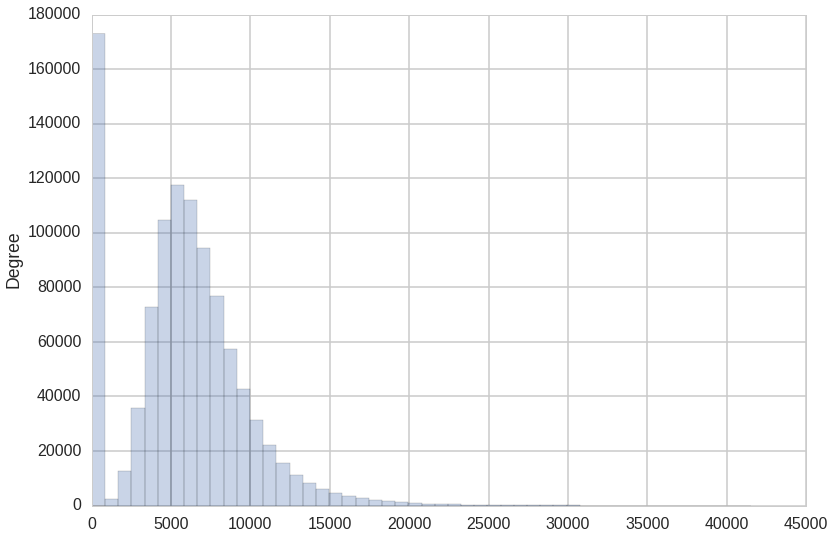

In [46]:
# Distribution of Sales variable
train_df.Sales.plot(kind='hist', bins=50, alpha=0.3);

** As you can see this is a bimodal distribution, there are several stores with 0 sales and others with considerably high values for sales. We need to take a look into this. **

In [47]:
mask = (train_df.Sales == 0)
stores_with_no_sales = train_df[mask]

In [50]:
# Count of number of stores with no reported sales
num_stores_with_no_sales = stores_with_no_sales.shape[0]
num_stores_with_no_sales

172871

In [51]:
# Percentage of stores with no reported sales

print '%f stores have no sales reported ' %(num_stores_with_no_sales / np.float(train_df.shape[0]) * 100)

16.994639 stores have no sales reported 


In [52]:
stores_with_no_sales.Open.value_counts()

0    172817
1        54
dtype: int64

** As you can see for most of these stores the figure was reported when they were closed which makes sense, as for other 54 instances, we would have to see as to what caused this. **

*** This also leads to questions like following : ***
* Are there any stores in the test data that were closed on that particular day ?
* How to deal with missing values for the feature Open in the test set ?

In [53]:
# Let's try to answer this first question by looking at the test dataset
test_df.Open.value_counts()

1    35093
0     5984
dtype: int64

** As it seems that our model would be tested on stores that were closed on a particular day. **

*** List out columns in the training and test dataset ***

In [58]:
# column names in the training data
print 'Feature Names for training data are %s ' %(', '.join(train_df.columns.values))

Feature Names for training data are Store, DayOfWeek, Date, Sales, Customers, Open, Promo, StateHoliday, SchoolHoliday 


In [59]:
# column names in the test data
print 'Feature Names for test data are %s ' %(', '.join(test_df.columns.values))

Feature Names for test data are Id, Store, DayOfWeek, Date, Open, Promo, StateHoliday, SchoolHoliday 


** As you can see `Customer` feature is not captured for test set, so we would include this feature in our modelling phase. **

### Relationship between whether store is open or not with sales of the store

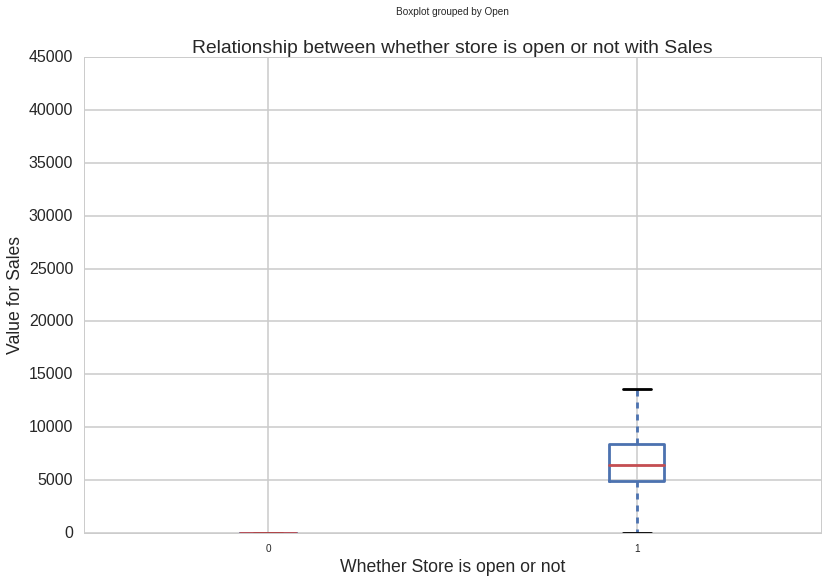

In [60]:
train_df.boxplot(column='Sales', by='Open')
plt.xlabel('Whether Store is open or not')
plt.ylabel('Value for Sales')
plt.title('Relationship between whether store is open or not with Sales');

** As you can see stores that were closed have zero as the reported value for sales **

### Effect of promotion on sales

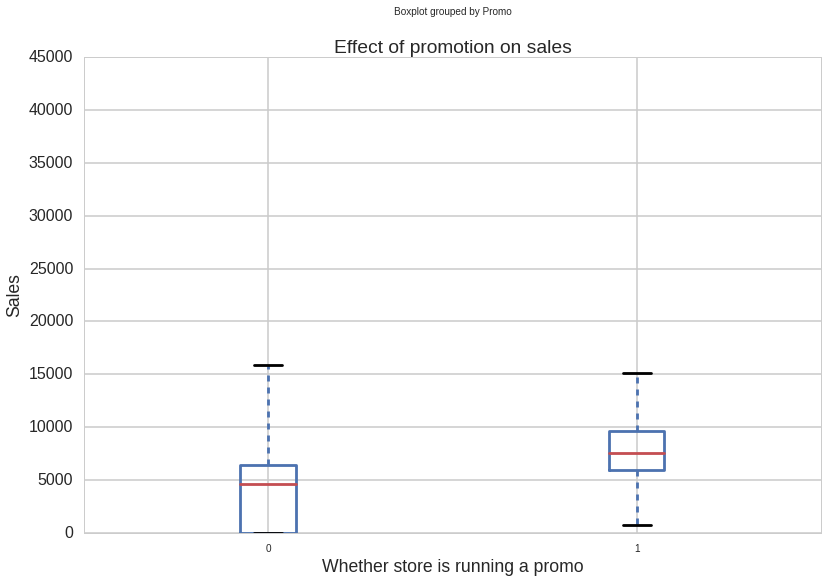

In [62]:
train_df.boxplot(column='Sales', by='Promo')
plt.xlabel('Whether store is running a promo')
plt.ylabel('Sales')
plt.title('Effect of promotion on sales');

*** Stores that are running a promotion have higher median sales than ones that are not ***

There is also temporal element to this dataset, which means that data is recorded for a particular store on a particular date with all the above mentioned features, so we would also have to keep this thing in mind.

## Relationship between day of week and sales

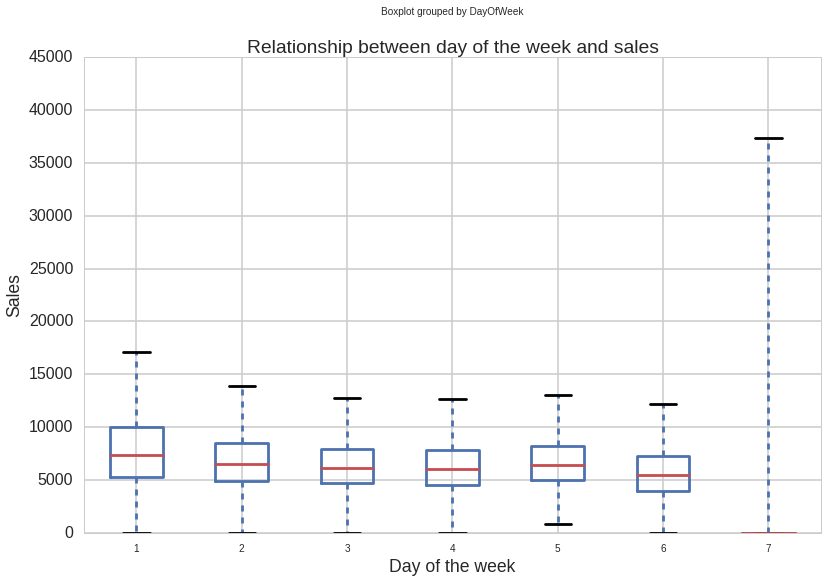

In [66]:
# Monday = 1, Tuesday = 2 and so on...
train_df.boxplot(column='Sales', by='DayOfWeek')
plt.xlabel('Day of the week')
plt.ylabel('Sales')
plt.title('Relationship between day of the week and sales');

*** As you can see we have no sales on Sunday and Monday seems to be the day of week with highest median value for sales ***

## Simple Linear Regression Model

In [71]:
from statsmodels.formula.api import ols

m = ols('Sales ~ Store + Promo', train_df).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.205
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                 1.309e+05
Date:                Sun, 11 Oct 2015   Prob (F-statistic):               0.00
Time:                        23:47:06   Log-Likelihood:            -9.7248e+06
No. Observations:             1017209   AIC:                         1.945e+07
Df Residuals:                 1017206   BIC:                         1.945e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4371.9903      7.322    597.098      0.0

*** P-value of the variable in question is 0 which indicates that the variable is certainly of interest ***

Let's see how our model fitted the data

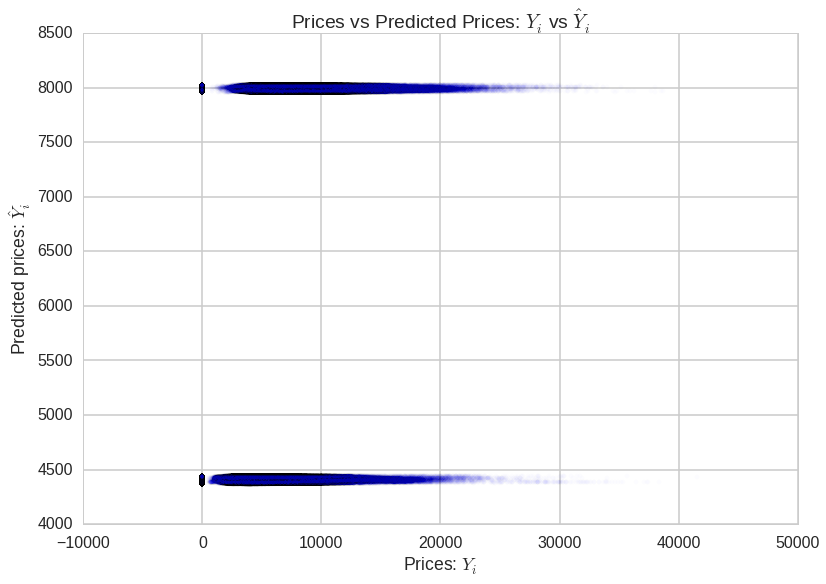

In [76]:
plt.scatter(train_df['Sales'], m.fittedvalues, alpha=0.01)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$");

** This does not look good as we are a predicting constant value just under 4500 for majority of the values and then predicting 8000 for most of the other values. **

## Random Forest Model

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [77]:
rf = RandomForestRegressor().fit(train_df[['Store', 'Promo']], train_df.Sales)

In [78]:
rf_fitted_values = rf.predict(train_df[['Store', 'Promo']])

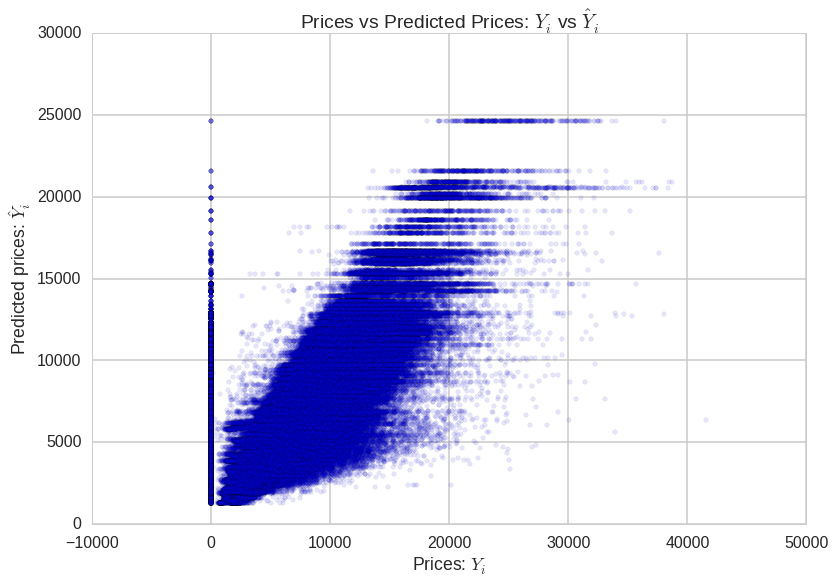

In [80]:
plt.scatter(train_df['Sales'], rf_fitted_values, alpha=0.1)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$");

** This looks much better, most of the predictions are below 45 degree line and we need to take care of the fact that we are predicting positive value when the original value is actually 0. **

So what we plan to do is create a training and testing split, we would have all of the data except 6 weeks for training and rest would be set aside for testing.

In [319]:
rossman.split_train_test()

In [320]:
training_examples = rossman.training_examples
test_examples = rossman.test_examples

In [210]:
training_examples_open_stores = training_examples[training_examples.Open == 1]
training_examples_open_stores = training_examples_open_stores[training_examples_open_stores.Date > '2014-01-31']

X_train = training_examples_open_stores[['Store', 'Promo', 'DayOfWeek']]
y_train = training_examples_open_stores.Sales

In [211]:
# print the shape of the training set
print 'Shape of the training examples ', (X_train.shape)

Shape of the training examples  (393247, 3)


In [212]:
test_examples_open_stores = test_examples[test_examples.Open == 1]

X_test = test_examples_open_stores[['Store', 'Promo', 'DayOfWeek']]
y_test = test_examples_open_stores.Sales

In [213]:
# print the shape of the test set
print 'Shape of the training examples ', (X_test.shape)

Shape of the training examples  (84491, 3)


In [214]:
# Fit a random forest model
rf = RandomForestRegressor().fit(X_train, y_train)

In [215]:
# predict on the test set
rf_test_fittedvalues = rf.predict(X_test)

In [216]:
# rmspe on the test set
print 'RMSPE on the test set %f ' %(rossman.rmspe(y_test.values, rf_test_fittedvalues))

RMSPE on the test set 0.141110 


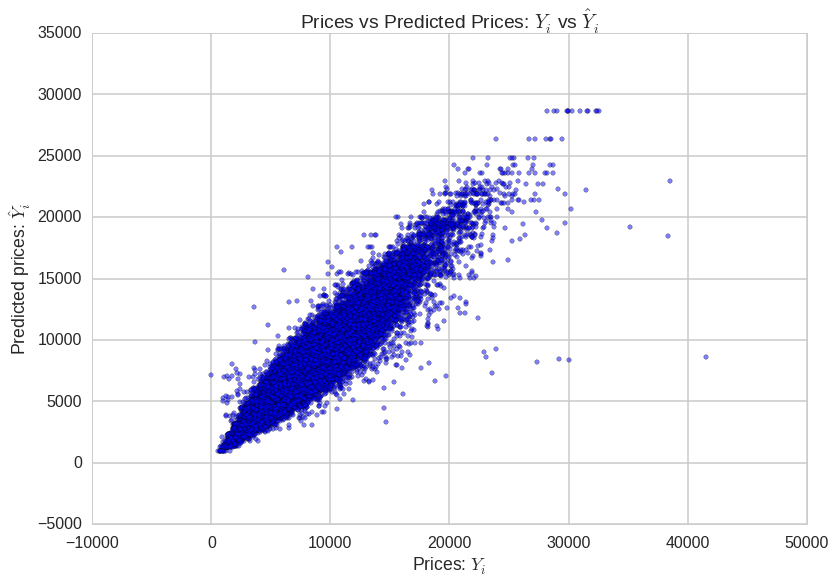

In [217]:
plt.scatter(y_test, rf_test_fittedvalues, alpha=0.5)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$");

## We can also take logarithmic transformation for Sales to see how it affects the outcome

In [46]:
training_examples_open_stores = training_examples[training_examples.Open == 1]
training_examples_open_stores = training_examples_open_stores[training_examples_open_stores.Date > '2014-05-31']

X_train = training_examples_open_stores[['Store', 'Promo', 'DayOfWeek']]
y_train = np.log1p(training_examples_open_stores.Sales)

In [47]:
test_examples_open_stores = test_examples[test_examples.Open == 1]

X_test = test_examples_open_stores[['Store', 'Promo', 'DayOfWeek']]
y_test = np.log1p(test_examples_open_stores.Sales)

In [48]:
# Fit a random forest model
rf = RandomForestRegressor().fit(X_train, y_train)

In [49]:
# predict on the test set
rf_test_fittedvalues = rf.predict(X_test)

In [247]:
# print rmspe on the test set
print 'RMSPE on test set %f ' %(rossman.rmspe(np.expm1(y_test.values), np.expm1(rf_test_fittedvalues)))

RMSPE on test set 0.138913 


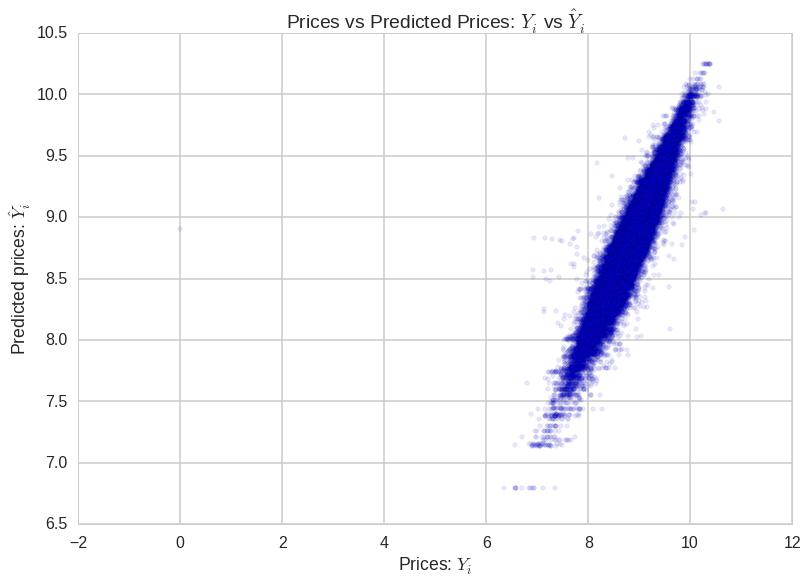

In [248]:
plt.scatter(y_test, rf_test_fittedvalues, alpha=.1)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$");

** This looks much better many of the predictions fall across the 45 degree line **

## Effect of State Holidays

In [16]:
train_df.StateHoliday.unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

*** These are several types of state holidays a - Public Holiday b - Easter Holiday c - Christmas and 0 is None, but somehow 0 is recorded both as a string and number we would have to correct this. ***

In [22]:
test_df.StateHoliday.unique()

array(['0', 'a'], dtype=object)

** We are testing our system out on weeks which having only public holidays **

In [83]:
fix_holidays = lambda x: str(x)

In [84]:
training_examples_open_stores = training_examples[training_examples.Open == 1]
training_examples_open_stores.loc[:, 'StateHoliday'] = training_examples_open_stores.StateHoliday.map(fix_holidays)

In [86]:
lbl = LabelEncoder()
training_examples_open_stores.loc[:, 'StateHoliday'] = lbl.fit_transform(training_examples_open_stores.StateHoliday)

In [87]:
training_examples_open_stores = training_examples_open_stores[training_examples_open_stores.Date > '2014-03-31']

X_train = training_examples_open_stores[['Store', 'Promo', 'DayOfWeek', 'StateHoliday']]
y_train = np.log1p(training_examples_open_stores.Sales)

In [88]:
test_examples_open_stores = test_examples[test_examples.Open == 1]
test_examples_open_stores.loc[:, 'StateHoliday'] = lbl.transform(test_examples_open_stores.StateHoliday)

X_test = test_examples_open_stores[['Store', 'Promo', 'DayOfWeek', 'StateHoliday']]
y_test = np.log1p(test_examples_open_stores.Sales)

In [89]:
# shape of the training and test set
print 'Training set ', X_train.shape, ' and Test set ', X_test.shape

Training set  (337446, 4)  and Test set  (84491, 4)


In [99]:
# Fit a random forest model
rf = RandomForestRegressor(n_estimators=50, n_jobs=-1).fit(X_train, y_train)

In [100]:
# predict on the test set
rf_test_fittedvalues = rf.predict(X_test)

In [101]:
# print rmspe on the test set
print 'RMSPE on test set %f ' %(rossman.rmspe(np.expm1(y_test.values), np.expm1(rf_test_fittedvalues)))

RMSPE on test set 0.133834 


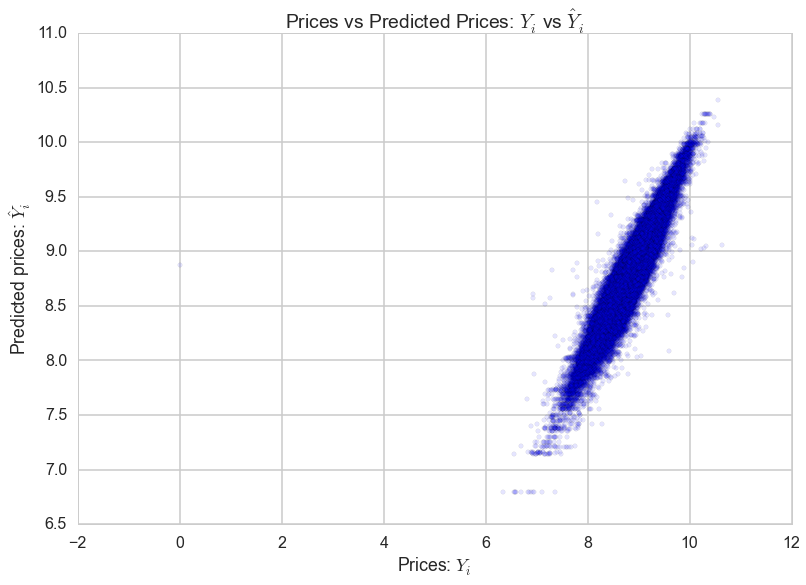

In [102]:
plt.scatter(y_test, rf_test_fittedvalues, alpha=.1)
plt.xlabel("Prices: $Y_i$")
plt.ylabel("Predicted prices: $\hat{Y}_i$")
plt.title("Prices vs Predicted Prices: $Y_i$ vs $\hat{Y}_i$");

## Merge Stores Data

In [563]:
rossman.merge_stores_data()

In [564]:
train_df, test_df = rossman.train_df, rossman.test_df

In [565]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270,9,2008,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570,11,2007,1,13,2010,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130,12,2006,1,14,2011,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620,9,2009,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910,4,2015,0,NaN,NaN,NaN


In [566]:
# print data type of all the collected features
train_df.dtypes

Store                                 int64
DayOfWeek                             int64
Date                         datetime64[ns]
Sales                                 int64
Customers                             int64
Open                                  int64
Promo                                 int64
StateHoliday                         object
SchoolHoliday                         int64
StoreType                            object
Assortment                           object
CompetitionDistance                 float64
CompetitionOpenSinceMonth           float64
CompetitionOpenSinceYear            float64
Promo2                                int64
Promo2SinceWeek                     float64
Promo2SinceYear                     float64
PromoInterval                        object
dtype: object

## Relationship between Assortment and Sales

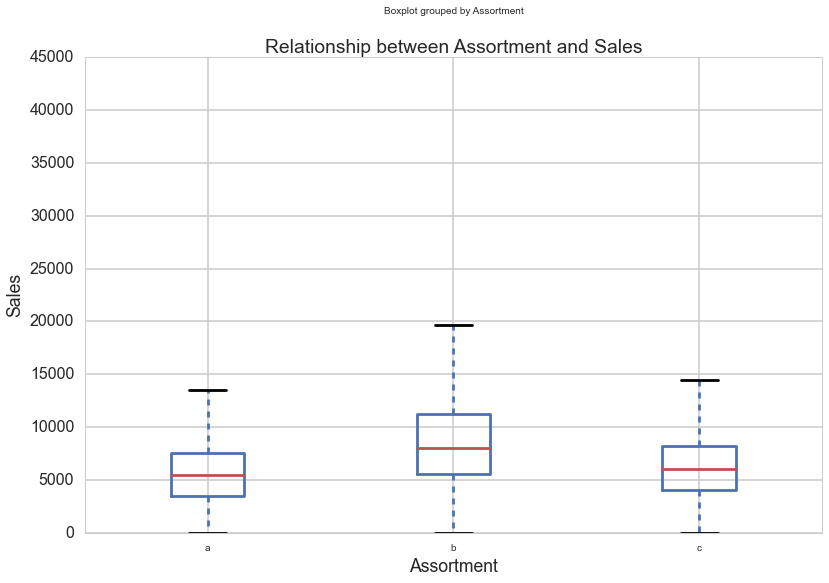

In [443]:
train_df.boxplot(column='Sales', by='Assortment')
plt.xlabel('Assortment')
plt.ylabel('Sales')
plt.title('Relationship between Assortment and Sales');

** Assortment level b certainly has impact on sales **

## Relationship between competition distance and sales

In [567]:
c = train_df.groupby('Store')

In [568]:
comp_dist_by_store = c.CompetitionDistance.apply(np.mean)
sales_by_store = c.Sales.mean()

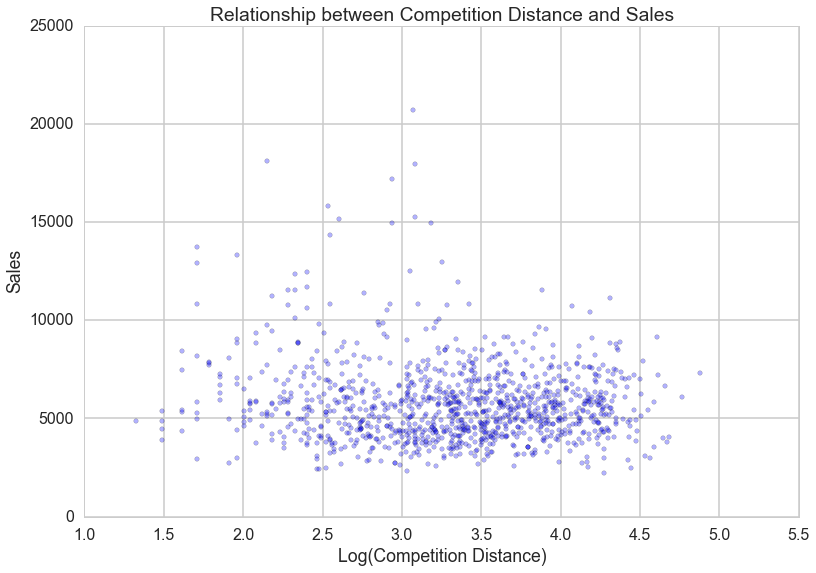

In [569]:
plt.scatter(np.log10(1 + comp_dist_by_store), sales_by_store, alpha=.3)
plt.xlabel('Log(Competition Distance)')
plt.ylabel('Sales')
plt.title('Relationship between Competition Distance and Sales');

In [570]:
rossman.split_train_test()

In [571]:
training_examples = rossman.training_examples
test_examples = rossman.test_examples

In [572]:
training_examples = training_examples[training_examples.Date > '2014-03-31']
training_examples = training_examples[training_examples.Sales > 0]

In [581]:
# create dummy variables for Store Type and Assortment
# training_examples_open_store = training_examples[training_examples.Open == 1]
training_examples_open_store = training_examples
training_examples_open_store = pd.concat([training_examples_open_store, pd.get_dummies(training_examples_open_store.StoreType, prefix='StoreType')], axis=1)
training_examples_open_store = pd.concat([training_examples_open_store, pd.get_dummies(training_examples_open_store.Assortment, prefix='Assortment')], axis=1)

In [582]:
lbl = LabelEncoder()

In [583]:
# add month as a derived variable from date
# training_examples_open_store.loc[:, 'Month'] = training_examples_open_store.Date.dt.month

In [584]:
# training_examples_open_store.loc[:, 'StateHoliday'] = training_examples_open_store.StateHoliday.astype(str)
# training_examples_open_store.loc[:, 'StateHoliday'] = lbl.fit_transform(training_examples_open_store.StateHoliday)

In [585]:
training_examples_open_store.columns

Index([u'Store', u'DayOfWeek', u'Date', u'Sales', u'Customers', u'Open', u'Promo', u'StateHoliday', u'SchoolHoliday', u'StoreType', u'Assortment', u'CompetitionDistance', u'CompetitionOpenSinceMonth', u'CompetitionOpenSinceYear', u'Promo2', u'Promo2SinceWeek', u'Promo2SinceYear', u'PromoInterval', u'StoreType_a', u'StoreType_b', u'StoreType_c', u'StoreType_d', u'Assortment_a', u'Assortment_b', u'Assortment_c'], dtype='object')

In [586]:
training_examples_open_store.CompetitionDistance.fillna(0, inplace=True)
training_examples_open_store.CompetitionOpenSinceYear.fillna(2013, inplace=True)
training_examples_open_store.CompetitionOpenSinceMonth.fillna(7, inplace=True)

training_examples_open_store.loc[:, 'CompetitionDistance'] = np.log10(1 + training_examples_open_store.CompetitionDistance)

In [587]:
features = ['Store', 'Promo', 'StoreType_a', 'StoreType_b',
            'StoreType_c', 'DayOfWeek', 'Assortment_a', 'Assortment_b','CompetitionDistance', 
            'Promo2', 'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth', 'Open']

In [588]:
X_train = training_examples_open_store[features]
y_train = np.log1p(training_examples_open_store.Sales)

In [589]:
# test_examples_open_store = test_examples[test_examples.Open == 1]
test_examples_open_store = test_examples
test_examples_open_store = pd.concat([test_examples_open_store, pd.get_dummies(test_examples_open_store.StoreType, prefix='StoreType')], axis=1)
test_examples_open_store = pd.concat([test_examples_open_store, pd.get_dummies(test_examples_open_store.Assortment, prefix='Assortment')], axis=1)

In [590]:
# test_examples_open_store.loc[:, 'Month'] = test_examples_open_store.Date.dt.month

In [591]:
# test_examples_open_store.loc[:, 'StateHoliday'] = lbl.transform(test_examples_open_store.StateHoliday)

In [592]:
test_examples_open_store.CompetitionDistance.fillna(0, inplace=True)
test_examples_open_store.CompetitionOpenSinceYear.fillna(2013, inplace=True)
test_examples_open_store.CompetitionOpenSinceMonth.fillna(7, inplace=True)

test_examples_open_store.loc[:, 'CompetitionDistance'] = np.log10(1 + test_examples_open_store.CompetitionDistance)

In [593]:
X_test = test_examples_open_store[features]
y_test = np.log1p(test_examples_open_store.Sales)

In [594]:
# fit a random forest model
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)

In [597]:
# predict on the test set
rf_test_fittedvalues = rf.predict(X_test)

In [598]:
# print rmspe on the test set
print 'RMSPE on test set %f ' %(rossman.rmspe(np.expm1(y_test.values), np.expm1(rf_test_fittedvalues)))

RMSPE on test set 0.124242 


In [599]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=10).fit(X_train, y_train)

In [600]:
etr_test_fittedvalues = etr.predict(X_test)

In [601]:
# print rmspe on the test set
print 'RMSPE on test set %f ' %(rossman.rmspe(np.expm1(y_test.values), np.expm1(etr_test_fittedvalues)))

RMSPE on test set 0.123839 


### Extreme Gradient Boosting

In [602]:
def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w


def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe


def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [603]:
import xgboost as xgb

In [617]:
# paramlist
params = {"objective": "reg:linear",
          "eta": 0.3,
          "max_depth": 15,
          "silent": 1,
          }
num_trees = 100

In [618]:
dtrain = xgb.DMatrix(X_train[:-10000], y_train[:-10000])
dvalid = xgb.DMatrix(X_train[-10000:], y_train[-10000:])

watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_trees, evals=watchlist, feval=rmspe_xg, verbose_eval=True)

[0]	eval-rmspe:0.996798	train-rmspe:0.996900
[1]	eval-rmspe:0.981297	train-rmspe:0.981824
[2]	eval-rmspe:0.937515	train-rmspe:0.939143
[3]	eval-rmspe:0.855455	train-rmspe:0.859212
[4]	eval-rmspe:0.740685	train-rmspe:0.747931
[5]	eval-rmspe:0.610559	train-rmspe:0.622794
[6]	eval-rmspe:0.483796	train-rmspe:0.503227
[7]	eval-rmspe:0.373777	train-rmspe:0.401786
[8]	eval-rmspe:0.286559	train-rmspe:0.325227
[9]	eval-rmspe:0.222223	train-rmspe:0.273655
[10]	eval-rmspe:0.177513	train-rmspe:0.241950
[11]	eval-rmspe:0.150583	train-rmspe:0.225060
[12]	eval-rmspe:0.133994	train-rmspe:0.220570
[13]	eval-rmspe:0.126605	train-rmspe:0.217991
[14]	eval-rmspe:0.122357	train-rmspe:0.217218
[15]	eval-rmspe:0.120402	train-rmspe:0.222046
[16]	eval-rmspe:0.119793	train-rmspe:0.223027
[17]	eval-rmspe:0.120131	train-rmspe:0.223903
[18]	eval-rmspe:0.118378	train-rmspe:0.227172
[19]	eval-rmspe:0.116896	train-rmspe:0.226799
[20]	eval-rmspe:0.114622	train-rmspe:0.225942
[21]	eval-rmspe:0.113370	train-rmspe:0.22544

In [619]:
dtest = xgb.DMatrix(X_test)

In [620]:
xgb_test_fitted_values = bst.predict(dtest)

In [621]:
# print rmspe on the test set
print 'RMSPE on test set %f ' %(rossman.rmspe(np.expm1(y_test.values), np.expm1(xgb_test_fitted_values)))

RMSPE on test set 0.123730 


In [622]:
# Ensemble of RF and XGB model

In [637]:
ensemble_fittedvalues = (.2 * np.expm1(rf_test_fittedvalues) + .8 * np.expm1(xgb_test_fitted_values))

In [638]:
# rmspe of ensemble models
print 'RMSPE on the test set %f ' %(rossman.rmspe(np.expm1(y_test.values), ensemble_fittedvalues))

RMSPE on the test set 0.123770 


In [164]:
# Prepare the data for full training
training_data_with_open_stores = train_df[train_df.Sales > 0]
mask = training_data_with_open_stores.Date > '2014-03-31'
training_data_with_open_stores = training_data_with_open_stores[mask]
training_data_with_open_stores = pd.concat([training_data_with_open_stores, pd.get_dummies(training_data_with_open_stores.StoreType, prefix='StoreType')], axis=1)
training_data_with_open_stores = pd.concat([training_data_with_open_stores, pd.get_dummies(training_data_with_open_stores.Assortment, prefix='Assortment')], axis=1)
# training_data_with_open_stores.loc[:, 'StateHoliday'] = training_data_with_open_stores.StateHoliday.astype(str)
# training_data_with_open_stores.loc[:, 'StateHoliday'] = lbl.fit_transform(training_data_with_open_stores.StateHoliday)
training_data_with_open_stores.CompetitionDistance.fillna(0, inplace=True)
training_data_with_open_stores.CompetitionOpenSinceYear.fillna(2013, inplace=True)
training_data_with_open_stores.CompetitionOpenSinceMonth.fillna(7, inplace=True)

training_data_with_open_stores.loc[:, 'CompetitionDistance'] = np.log10(1 + training_data_with_open_stores.CompetitionDistance)

X_train_full = training_data_with_open_stores[features]
y_train_full = np.log1p(training_data_with_open_stores.Sales)

In [166]:
# train rf on the full dataset
rf.fit(X_train_full, y_train_full)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [197]:
test_df.Open.fillna(1, inplace=True)

In [198]:
# fill the missing values for Open in test dataset
test_data_open_store = test_df[test_df.Open == 1]
test_data_close_store = test_df[test_df.Open == 0]
test_data_open_store = pd.concat([test_data_open_store, pd.get_dummies(test_data_open_store.StoreType, prefix='StoreType')], axis=1)
test_data_open_store = pd.concat([test_data_open_store, pd.get_dummies(test_data_open_store.Assortment, prefix='Assortment')], axis=1)

test_data_open_store.loc[:, 'StateHoliday'] = lbl.transform(test_data_open_store.StateHoliday)
test_data_open_store.CompetitionDistance.fillna(0, inplace=True)

In [199]:
X_test_full = test_data_open_store[features]

In [201]:
rf_final_fitted_values = np.expm1(rf.predict(X_test_full))

In [202]:
closed_shops_preds = np.array([0.0] * test_data_close_store.shape[0])

In [203]:
ids = np.hstack([test_data_open_store.Id.values, test_df[test_df.Open == 0].Id.values])

In [204]:
preds_rf = np.hstack([rf_final_fitted_values, closed_shops_preds])

In [176]:
train = xgb.DMatrix(X_train_full, y_train_full)

In [177]:
bst = xgb.train(params, train, num_trees, feval=rmspe_xg)

In [205]:
test = xgb.DMatrix(X_test_full)

In [206]:
xgb_preds = np.expm1(bst.predict(test))

In [207]:
preds_xgb = np.hstack([xgb_preds, closed_shops_preds])

In [209]:
final_preds = (.2 * preds_rf + .8 * preds_xgb)

In [210]:
submission_df = pd.DataFrame({'Id': ids, 'Sales': final_preds})
submission_df.to_csv('./submissions/ensemble_rf_xgb.csv', index=False)

In [190]:
test_df.shape

(41088, 17)

In [8]:
# Let's decompose date into year and month
rossman_train_df.loc[:, 'Month'] = rossman_train_df.Date.dt.month
rossman_test_df.loc[:, 'Month'] = rossman_test_df.Date.dt.month

rossman_train_df.loc[:, 'Year'] = rossman_train_df.Date.dt.year
rossman_test_df.loc[:, 'Year'] = rossman_test_df.Date.dt.year

In [9]:
# convert state holiday from factor to numeric
from sklearn.preprocessing import LabelEncoder

lbl = LabelEncoder()
lbl.fit_transform(rossman_train_df.StateHoliday)

array([1, 1, 1, ..., 2, 2, 2])

In [10]:
rossman_train_df.loc[:, 'StateHoliday'] = lbl.transform(rossman_train_df.StateHoliday)
rossman_test_df.loc[:, 'StateHoliday'] = lbl.transform(rossman_test_df.StateHoliday)

In [401]:
# lets look into correlations
rossman_train_df.corr()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year
Store,1.000000,-0.000008,0.005126,0.024325,-0.000047,0.000058,-0.000072,0.000641,0.001467,0.000290
DayOfWeek,-0.000008,1.000000,-0.462125,-0.386445,-0.528963,-0.392925,-0.024370,-0.205388,-0.005362,0.001937
Sales,0.005126,-0.462125,1.000000,0.894711,0.678472,0.452345,-0.140730,0.085124,0.048768,0.023519
Customers,0.024325,-0.386445,0.894711,1.000000,0.616768,0.316169,-0.133735,0.071568,0.038179,-0.001212
Open,-0.000047,-0.528963,0.678472,0.616768,1.000000,0.295042,-0.233225,0.086171,-0.000681,-0.001009
Promo,0.000058,-0.392925,0.452345,0.316169,0.295042,1.000000,-0.013444,0.067483,-0.011747,0.024300
StateHoliday,-0.000072,-0.024370,-0.140730,-0.133735,-0.233225,-0.013444,1.000000,0.085372,0.086642,-0.064672
SchoolHoliday,0.000641,-0.205388,0.085124,0.071568,0.086171,0.067483,0.085372,1.000000,0.103282,-0.036535
Month,0.001467,-0.005362,0.048768,0.038179,-0.000681,-0.011747,0.086642,0.103282,1.000000,-0.269382
Year,0.000290,0.001937,0.023519,-0.001212,-0.001009,0.024300,-0.064672,-0.036535,-0.269382,1.000000


## Sampling

In [11]:
def get_data_between_range(start_date, end_date):
    mask = (rossman_train_df.Date >= start_date) & (rossman_train_df.Date < end_date)
    return rossman_train_df[mask]

## Questions

In [194]:
store_data_2015 = get_data_between_range('2015-01-01', '2015-08-01')
store_data_2014 = get_data_between_range('2014-01-01', '2014-08-01')
store_data_2013 = get_data_between_range('2013-01-01', '2013-08-01')

In [195]:
# sales pattern for different stores over 3 years
store_data_2015 = store_data_2015[['Store', 'Date', 'Sales']]
grouped_by_store_2015 = store_data_2015.groupby(['Store', 'Date']).mean()

store_data_2014 = store_data_2014[['Store', 'Date', 'Sales']]
grouped_by_store_2014 = store_data_2014.groupby(['Store', 'Date']).mean()

store_data_2013 = store_data_2013[['Store', 'Date', 'Sales']]
grouped_by_store_2013 = store_data_2013.groupby(['Store', 'Date']).mean()

In [196]:
store_sales_by_date_2015 = grouped_by_store_2015.unstack(1)
store_sales_by_date_2014 = grouped_by_store_2014.unstack(1)
store_sales_by_date_2013 = grouped_by_store_2013.unstack(1)

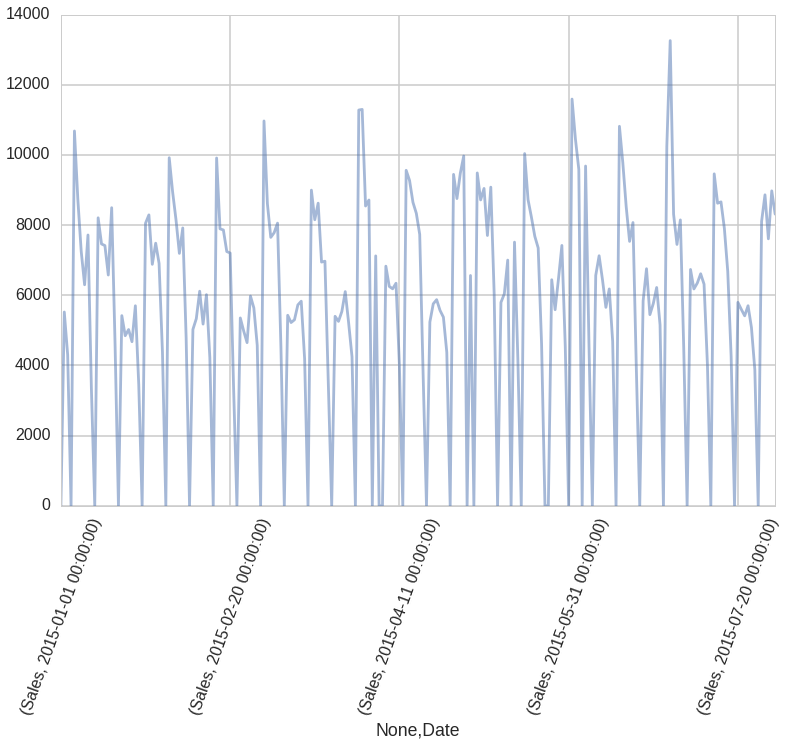

In [201]:
# plot the sales for some of the stores
store_idx = 3
store_sales_by_date_2015.ix[store_idx].plot(alpha=0.5)
plt.xticks(rotation=70);

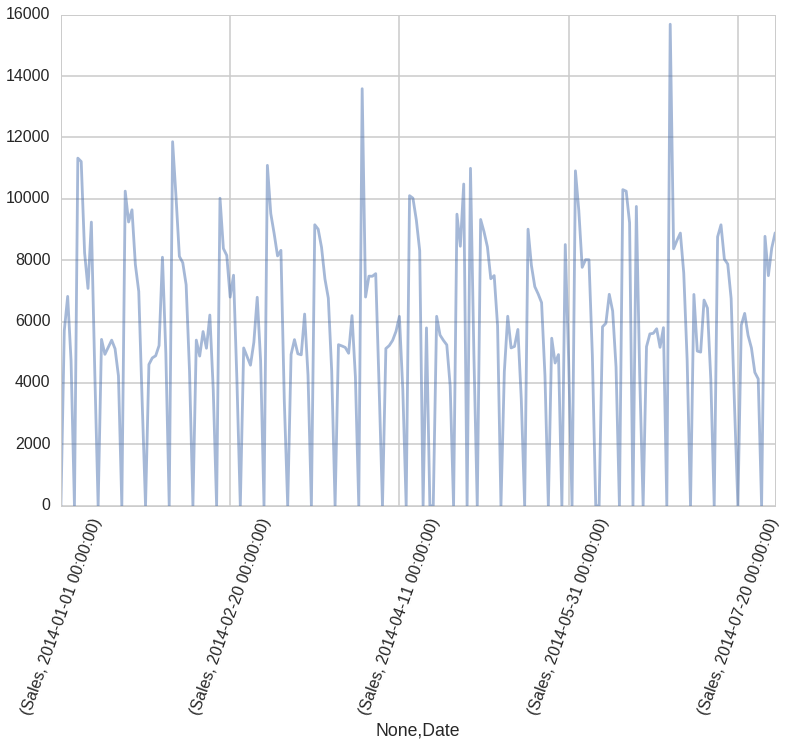

In [202]:
store_sales_by_date_2014.ix[store_idx].plot(alpha=.5)
plt.xticks(rotation=70);

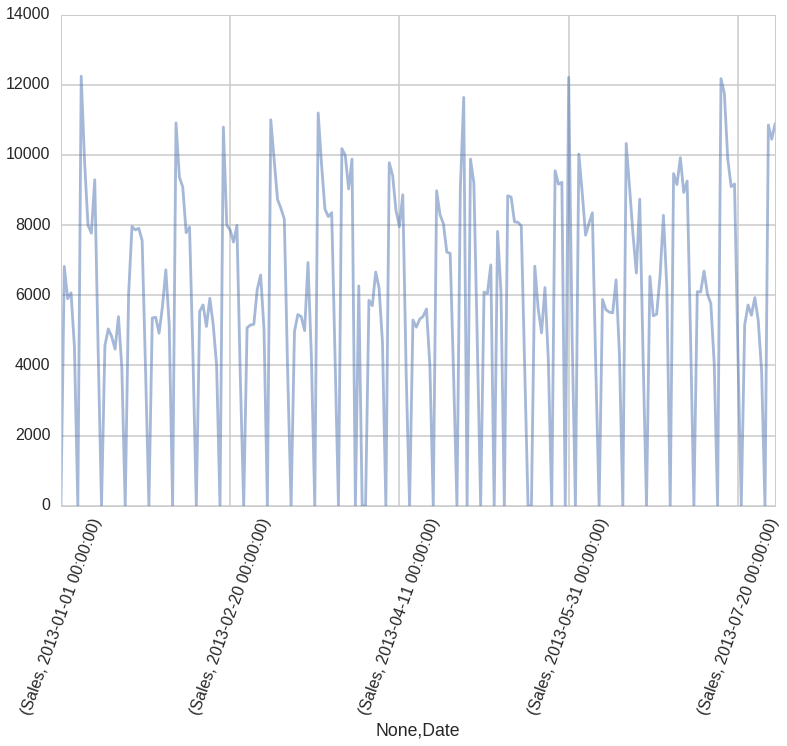

In [203]:
store_sales_by_date_2013.ix[store_idx].plot(alpha=.5)
plt.xticks(rotation=70);

In [16]:
# features to consider
features_to_consider = rossman_train_df.columns.drop(['Date', 'Sales', 'Customers'])

## Train Test Split

In [12]:
rossman_train_examples = get_data_between_range('2015-01-01', '2015-03-01')
rossman_test_examples = rossman_train_df[rossman_train_df.Date >= '2015-03-31']

In [13]:
rossman_train_target = rossman_train_examples.Sales
rossman_test_target = rossman_train_df[rossman_train_df.Date >= '2015-03-31'].Sales

In [14]:
# size of the training and testing examples
print 'Size of the training set %d ' %(rossman_train_examples.shape[0])

Size of the training set 65785 


In [15]:
# size of the testing examples
print 'Size of the test set %d ' %(rossman_test_examples.shape[0])

Size of the test set 137145 


## Modelling

In [17]:
train_data = rossman_train_examples[features_to_consider]
train_target = np.log1p(rossman_train_target)

In [18]:
test_data = rossman_test_examples[features_to_consider]
test_target = np.log1p(rossman_test_target)

## Linear Regression

In [420]:
lr = LinearRegression()
lr.fit(train_data, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [436]:
# prediction on the training examples
train_est = lr.predict(train_data)

In [440]:
# performance on the training set
print 'RMSPE on the trainig set %f ' %(rmspe(np.expm1(train_target.values), np.expm1(train_est)))

RMSPE on the trainig set 0.446051 


In [441]:
# prediction on the test examples
test_est = lr.predict(test_data)

In [443]:
# performance on the test set
print 'RMSPE on the test set %f ' %(rmspe(np.expm1(test_target.values), np.expm1(test_est)))

RMSPE on the test set 0.384481 


## Random Forest Regressor

In [19]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)
rf.fit(train_data, train_target)

In [351]:
# prediction on the training examples
train_est_rf = rf.predict(train_data)

In [352]:
# performance on the training set
print 'RMSPE on the training set %f ' %(rmspe(train_target.values, train_est_rf))

RMSPE on the training set 0.228212 


In [353]:
# predictions on the test examples
test_est_rf = rf.predict(test_data)

In [354]:
# performance on the test set
print 'RMSPE on the test set %f ' %(rmspe(test_target.values, test_est_rf))

RMSPE on the test set 0.154940 


## Extra Trees Regression

In [355]:
from sklearn.ensemble import ExtraTreesRegressor

In [356]:
etr = ExtraTreesRegressor(n_estimators=10)
etr.fit(train_data, train_target)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [357]:
train_est_etr = etr.predict(train_data)

In [358]:
# performance on the training set
print 'RMSPE on the training set %f ' %(rmspe(train_target.values, train_est_etr))

RMSPE on the training set 0.228974 


In [359]:
# predictions on the test examples
test_est_etr = etr.predict(test_data)

In [360]:
# performance on the test examples
print 'RMSPE on the test set %f ' %(rmspe(test_target.values, test_est_etr)) 

RMSPE on the test set 0.186083 


## Cross Validation

In [121]:
from sklearn.metrics import make_scorer

rmspe_scorer = make_scorer(rmspe, greater_is_better=False)

In [122]:
from sklearn.cross_validation import cross_val_score, ShuffleSplit

rf = RandomForestRegressor()
cv = ShuffleSplit(train_data.shape[0], n_iter=3, test_size=0.3,
    random_state=0)

test_scores = cross_val_score(rf, train_data, train_target.values, cv=cv, n_jobs=-1, scoring=rmspe_scorer)
test_scores

array([-0.14812795, -0.14772508, -0.1561489 ])

## Learning Curves

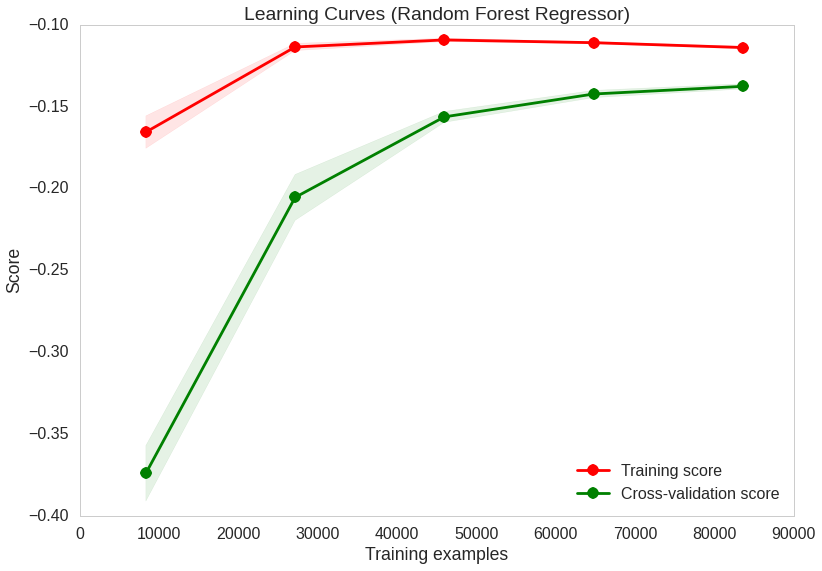

In [147]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=rmspe_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

title = "Learning Curves (Random Forest Regressor)"
estimator = RandomForestRegressor()
plot_learning_curve(estimator, title, X_train, y_train.values, cv=cv, n_jobs=-1)
plt.show()

## Final Model preparation

In [215]:
# train linear regression on full training examples
lr.fit(train_data, train_target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [123]:
# train random forest regressor on all training examples
rf.fit(train_data, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [124]:
test_df = rossman_test_df[features_to_consider]

In [125]:
# fill missing values in Open with 1
test_df.fillna(1, inplace=True)

/home/abhishek/anaconda/lib/python2.7/site-packages/pandas/core/frame.py:2532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [192]:
linear_regression_preds = lr.predict(test_df)

In [126]:
rf_regression_preds = rf.predict(test_df)

## Create Submissions

In [127]:
def create_submission(ids, preds, filename):
    """
    Takes in ids and prediction for sales and submission filename
    
    Args:
    ids: Ids
    preds: Prediction for sales
    
    """
    
    submission_df = pd.DataFrame({'Id': ids, 'Sales': preds})
    submission_df.to_csv('./submissions/' + filename, index=False)
    

In [128]:
create_submission(rossman_test_df.Id.values, rf_regression_preds, 'rf_regression_preds_dataset.csv')